# COGS 108 - Final Project 

# Overview

In order to see whether or not there is a significant correlation between the weather and the number of rides made per day in New York, appropriate data has been gathered and analyzed. The weather is divided into three different attributes; temperature, wind speed, and humidity, for each hour during the day in May of 2014. These three attributes were analyzed against the number of rides made in each month, to see if we can visually see the correlation between these three attributes and the rides made.

# Names

- Zijian Liu
- Pin-Hsuan Chen
- Kyle Reed 
- Yunji Ryu
- Jing Wei

# Group Members IDs

- A15723355
- A14012598
- A11839833
- A15729483
- A14767336

# Research Question

Research question: How does the weather condition, specifically wind speed, temperature, humidity, and hourly weather description, affect the overall number of rides during the day in NYC?

We predict that these factor will correlate to the number of rides in some way. It is harder to say whether it will be a negative or positive correlation because unfavorable weather conditions can include either extremely low temperatures or extremely high temperatures. However, we predict ride counts to be higher on days with unfavorable weather conditions, such as thunderstorm or rain. For instance, if for a particular hour, the wind speed, humidity, and temperature are all relatively higher compared to the whole dataset, we predict the ride count to be higher as well. 





## Background and Prior Work

There were no prior Work done for our topic. But based on our experiences with acquiring rides in certain weather conditions, there are numerous reasons why one can consider getting a taxi/Uber compared to getting there by foot or other means. One of the main components that influences this decision is weather. Engineers in the New York State created a system to provide information about the road conditions in New York State, specifically catering towards the more haphazarad winter season, providing whether the highway will be blocked or not due to snow and ice operations. They also included a report for each of the observed years to include a more detailed descriptions of the road conditions and list how accurate their report was. But not much of these affected the road conditions during the non-winter seasons. Whether it's the wind travel advisory warnings, slippery driveways on a rainy day, drivers and the riders tend to be more wary of the environmental situations around the road regardless of the season, which affects their decision to get a ride or not, conclusively affecting the number of rides that are made In New York. In order to investigate this information, we decided to use our readily available public data to analyze and infer to the possible correlations listed in our research question and hypothesis.

References (include links):
- 1) https://www.dot.ny.gov/wta (New York State Winter Travel Advisory System for 2014 - 2015 winter season)
- 2) https://www.dot.ny.gov/divisions/engineering/technical-services/highway-data-services/traffic-data (Traffic Data Report based on various regions in New York State in 2014)

# Hypothesis


1. Temperature will have no effect on ride count
2. Wind speed will have no effect on ride count
3. Humidity will have no effect on ride count

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name: Historical Hourly Weather Data 2012-2017
- Link to the dataset: https://www.kaggle.com/selfishgene/historical-hourly-weather-data
- Number of observations: [to be filled]
- Description: This dataset includes hourly weather data for several cities


- Dataset Name: [to be filled]
- Link to the dataset: [rides link here]
- Number of observations: [to be filled]
- description: [to be filled]

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [35]:
## YOUR CODE HERE
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import datetime

# revised proposal: weather of date vs. trip numbers?






# Data cleaning

Describe your data cleaning steps here.

In [4]:
pickup_df = pd.read_csv('uber-raw-data-may14.csv')

weather_description_df = pd.read_csv('weather_description.csv')
###
#data frame: pickup_df contains trip data, weather_description_df contains weather data

# cleaning data, dropping everything not related to New York City 
weather_description_df = weather_description_df[['datetime','New York']].dropna()

# reading raw data for uber rides
pickup_df = pickup_df[['Date/Time']]
pickup_df.head()



# printing the first element in both data frame to see the format
print("WEATHER: "+ weather_description_df['datetime'].iloc[:3])
print("PICKUP:  "+ pickup_df['Date/Time'].iloc[:3])

print("--------")
''' 
How to drop data whose year and month doesn't match? i.e. dropping rows in which years aren't 2014
How to format the date so that everything is in sync with each other?
After cleaning, how to relate trip numbers at a certain time period with that time?
'''
#pickup_df['Date/Time'] = datetime.strptime(str, '%m-%d-%y')
weather_description_df['datetime'] = pd.to_datetime(weather_description_df['datetime'])

# this is how you convert timestamps object to str and use contains with it
weather_description_df = weather_description_df[weather_description_df['datetime'].astype(str).str.contains('2014-05')]
pickup_df['Date/Time'] = pd.to_datetime(pickup_df['Date/Time'])
print("AFTER CONVERSION: ")
pickup_df['Date/Time']
#weatherdesc_clean = 
weather_description_df[weather_description_df['datetime'].astype(str).str.contains('2014')]



1    WEATHER: 2012-10-01 13:00:00
2    WEATHER: 2012-10-01 14:00:00
3    WEATHER: 2012-10-01 15:00:00
Name: datetime, dtype: object
0    PICKUP:  5/1/2014 0:02:00
1    PICKUP:  5/1/2014 0:06:00
2    PICKUP:  5/1/2014 0:15:00
Name: Date/Time, dtype: object
--------
AFTER CONVERSION: 


,datetime,New York
13836,2014-05-01 00:00:00,moderate rain
13837,2014-05-01 01:00:00,moderate rain
13838,2014-05-01 02:00:00,moderate rain
13839,2014-05-01 03:00:00,heavy intensity rain
13840,2014-05-01 04:00:00,heavy intensity rain
13841,2014-05-01 05:00:00,heavy intensity rain
13842,2014-05-01 06:00:00,heavy intensity rain
13843,2014-05-01 07:00:00,heavy intensity rain
13844,2014-05-01 08:00:00,heavy intensity rain
13845,2014-05-01 09:00:00,heavy intensity rain


In [6]:
# calling count() on the column containing New York data to see the specific content for weather description
description_item = weather_description_df.groupby(["New York"]).count()
print(description_item)

                              datetime
New York                              
broken clouds                      106
few clouds                          43
fog                                 11
haze                                24
heavy intensity drizzle              1
heavy intensity rain                27
light intensity drizzle             10
light rain                         149
mist                               104
moderate rain                       19
overcast clouds                     61
scattered clouds                    65
sky is clear                       120
thunderstorm                         2
thunderstorm with heavy rain         1
very heavy rain                      1


In [8]:
# trying to understand data so that we could clean it
print(type(pickup_df['Date/Time'].iloc[0]))
print(pd.to_datetime(pickup_df['Date/Time'].iloc[0]))
#type(weather_description_df['datetime'].astype(str).iloc[0])


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2014-05-01 00:02:00


In [14]:
temperature_df = pd.read_csv('NewYork_Temperature_2014.csv')
temperature_df = temperature_df[['datetime','New York']].dropna()
temperature_df.describe()
print("All data related to weather should have 744 entries AFTER CLEANING. Rerun if result doesn't match up.")
print("Before cleaning, temperature_df has",temperature_df['datetime'].count(),"entries")

'''
Cleaning the data
As you can see, clearly, the temperature dataframe is NOT in neither farenheit nor celsius
We suspect it is in Kelvin.
Is it though?

Justification: We looked into the below link, found the temperature for May 1st and converted in into Kelvin,
it matches what we have in our dataframe.
https://www.timeanddate.com/weather/usa/new-york/historic?month=5&year=2014
'''

temperature_df
temperature_df = temperature_df[temperature_df['datetime'].astype(str).str.contains('2014-05')]
print("After cleaning, temperature_df has",temperature_df['datetime'].count(),"entries")
#converting temperature from kelvin to fahrenheit
for i in temperature_df.index.values:
    k_temp = temperature_df.loc[i,'New York']
    f_temp = 9/5*(k_temp-273.15)+32
    f_temp_2 = int(str(f_temp)[:2])
    temperature_df.loc[i,'New York'] = f_temp_2

    
wind_speed_df = pd.read_csv('Wind_speed_for_2014-2015.csv')
wind_speed_df = wind_speed_df[['datetime','New York']].dropna()
wind_speed_df = wind_speed_df[wind_speed_df['datetime'].astype(str).str.contains('2014-05')]

'''
TODO: renaming all columns for each dataframe
THEN: merge them into a same dataframe
'''
# renaming all the columns so that it correctly matches with types of data stored.
weather_description_df.rename(columns={'New York':'description'}, inplace=True)
temperature_df.rename(columns={'New York':'temperature'}, inplace=True)
wind_speed_df.rename(columns={'New York':'wind speed'}, inplace=True)


All data related to weather should have 744 entries AFTER CLEANING. Rerun if result doesn't match up.
Before cleaning, temperature_df has 8760 entries
After cleaning, temperature_df has 744 entries


In [5]:
#After running above, we can see the index from all dataframes do not match up. 
#This is due to the different set up for each of them.



weather_description_df = weather_description_df.reset_index(drop=True)
weather_description_df
temperature_df = temperature_df.reset_index(drop=True)
wind_speed_df = wind_speed_df.reset_index(drop=True)


weather_description_df = weather_description_df.join(temperature_df['temperature'])
weather_description_df = weather_description_df.join(wind_speed_df['wind speed'])
# let's see what our dataframe looks like
weather_description_df

,datetime,description,temperature,wind speed
0,2014-05-01 00:00:00,moderate rain,51.0,4
1,2014-05-01 01:00:00,moderate rain,52.0,5
2,2014-05-01 02:00:00,moderate rain,52.0,5
3,2014-05-01 03:00:00,heavy intensity rain,54.0,5
4,2014-05-01 04:00:00,heavy intensity rain,53.0,4
5,2014-05-01 05:00:00,heavy intensity rain,54.0,4
6,2014-05-01 06:00:00,heavy intensity rain,55.0,4
7,2014-05-01 07:00:00,heavy intensity rain,56.0,4
8,2014-05-01 08:00:00,heavy intensity rain,57.0,5
9,2014-05-01 09:00:00,heavy intensity rain,57.0,4


After cleaning all the different features for weather and joining them into a single dataframes, we can start to visualize them.

In [24]:
humidity_df = pd.read_csv('humidity.csv')
humidity_df = humidity_df[['datetime','New York']].dropna()
humidity_df = humidity_df[humidity_df['datetime'].astype(str).str.contains('2014-05')]
humidity_df.rename(columns={'New York':'humidity'}, inplace=True)
humidity_df = humidity_df.reset_index(drop=True)
humidity_df
#comment below line after running for the first time
#rerunning will fail due to two NaN values
#weather_description_df = weather_description_df.join(humidity_df['humidity'])
weather_description_df


,datetime,description,temperature,wind speed,ride count
0,2014-05-01 00:00:00,moderate rain,51.0,4,348
1,2014-05-01 01:00:00,moderate rain,52.0,5,179
2,2014-05-01 02:00:00,moderate rain,52.0,5,101
3,2014-05-01 03:00:00,heavy intensity rain,54.0,5,172
4,2014-05-01 04:00:00,heavy intensity rain,53.0,4,241
5,2014-05-01 05:00:00,heavy intensity rain,54.0,4,438
6,2014-05-01 06:00:00,heavy intensity rain,55.0,4,822
7,2014-05-01 07:00:00,heavy intensity rain,56.0,4,1274
8,2014-05-01 08:00:00,heavy intensity rain,57.0,5,1237
9,2014-05-01 09:00:00,heavy intensity rain,57.0,4,853


In [17]:
# counts_df contains data for Uber ride count in May 2014 from pickup_df, cleaned in a hourly fashion
counts_df = pd.read_csv('uber_hourly_counts_may.csv')
counts_df

humidity_df
# why 2 NaN?
# There were two missing entry for humidity in May


counts_df = counts_df.reset_index(drop=True)
counts_df.rename(columns={'Count':'ride count'}, inplace=True)

#weather_description_df = weather_description_df.join(counts_df['ride count'])
weather_description_df


,datetime,description,temperature,wind speed,ride count
0,2014-05-01 00:00:00,moderate rain,51.0,4,348
1,2014-05-01 01:00:00,moderate rain,52.0,5,179
2,2014-05-01 02:00:00,moderate rain,52.0,5,101
3,2014-05-01 03:00:00,heavy intensity rain,54.0,5,172
4,2014-05-01 04:00:00,heavy intensity rain,53.0,4,241
5,2014-05-01 05:00:00,heavy intensity rain,54.0,4,438
6,2014-05-01 06:00:00,heavy intensity rain,55.0,4,822
7,2014-05-01 07:00:00,heavy intensity rain,56.0,4,1274
8,2014-05-01 08:00:00,heavy intensity rain,57.0,5,1237
9,2014-05-01 09:00:00,heavy intensity rain,57.0,4,853


In [ ]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

## NY's Temperature in 2014


# Data Analysis & Results

In [ ]:
'''
cols_plot = ['description', 'temperature','wind speed', 'humidity']
axes = weather_description_df[cols_plot].plot(marker='.', alpha=0.1, linestyle='None', figsize=(11, 9), subplots=True)
for y_axis in axes:
    y_axis.set_ylabel('counts')
'''

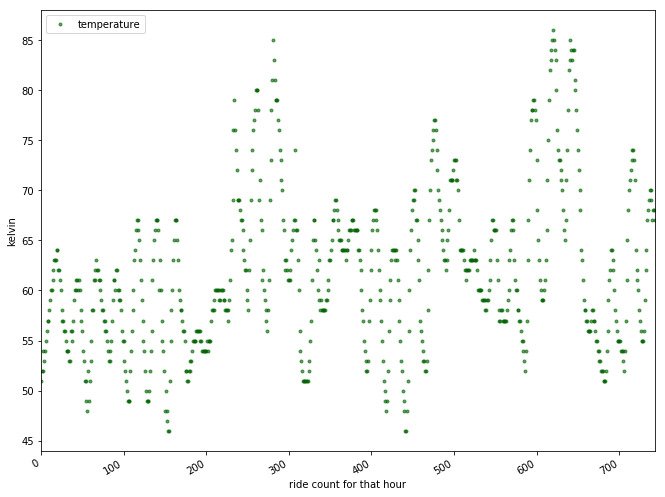

In [18]:
temperature_plot = ['temperature']
axes_temperature = weather_description_df[temperature_plot].plot(marker='.', color="darkgreen",
                                                                 alpha=0.6, 
                                                                 linestyle='None', 
                                                                 figsize=(11, 9), 
                                                                 subplots=True)
for y_axis in axes_temperature:
    y_axis.set_ylabel('kelvin')
for x_axis in axes_temperature:
    x_axis.set_xlabel('ride count for that hour')

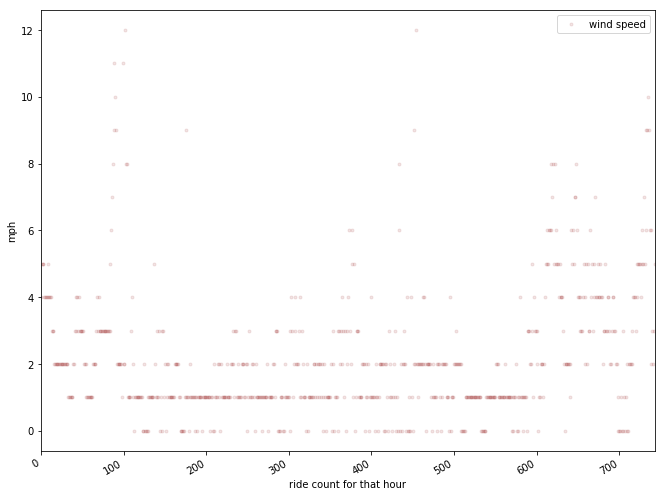

In [19]:
wind_speed_plot = ['wind speed']
axes_wind_speed = weather_description_df[wind_speed_plot].plot(marker='.', color="darkred",
                                                               alpha=0.1, 
                                                               linestyle='None', 
                                                               figsize=(11, 9), 
                                                               subplots=True)
for y_axis in axes_wind_speed:
    y_axis.set_ylabel('mph')
for x_axis in axes_wind_speed:
    x_axis.set_xlabel('ride count for that hour')

In [22]:
humidity_plot = ['humidity']
axes_humidity = weather_description_df[humidity_plot].plot(marker='.', color="blue",
                                                           alpha=0.1, 
                                                           linestyle='None', 
                                                           figsize=(11, 9), 
                                                           subplots=True)
for y_axis in axes_humidity:
    y_axis.set_ylabel('humidity')
    
for x_axis in axes_humidity:
    x_axis.set_xlabel('ride count for that hour')
    

KeyError: "None of [Index(['humidity'], dtype='object')] are in the [columns]"

Include cells that describe the steps in your data analysis.

In [ ]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

# Ethics & Privacy

The data set we are analyzing for this project is public data obtained from an open source. The data on its own does not reveal any private information about individual users as well as Uber drivers so we are not as concerned with personal privacy. However, analyzers could still easily extract a lot of information from these data. For instance, analyzing this data set could reveal users’ commute patterns and preferences. Though this does not point to a specific person, it could be information that could be sold to other companies for profit. From this, companies can target users based on their individual preferences. For example, they could distribute advertisements based on these preferences. Or, rideshare apps, like Uber, could take advantage of all these data and deliberately raise prices when the demand is high. 

# Conclusion & Discussion

*Fill in your discussion information here*